In [52]:
# Importing libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Dropout, LSTM, Flatten

In [2]:
# Load the datasets
df_weather = pd.read_csv('/Users/marika/Data Sets/Dataset-weather-prediction-dataset-processed.csv')
pleasant_weather = pd.read_csv('/Users/marika/Data Sets/Dataset-Answers-Weather_Prediction_Pleasant_Weather.csv')

# Developing an RNN (LSTM) Model for Weather Prediction

I am using the Recurrent Neural Network (RNN) model, a Long Short-Term Memory (LSTM) network, over a Convolutional Neural Network (CNN). The key reason for this choice is that RNNs, especially LSTMs, are well-suited for sequential data and time series analysis, which is what weather data typically is.

# Why RNN (LSTM) for Weather Prediction?

Sequential Data Handling: Weather data is inherently sequential, with patterns and dependencies across time. RNNs, particularly LSTMs, are designed to capture long-term dependencies and trends in sequential data, making them ideal for predicting future weather conditions based on past observations.

Temporal Dependencies: Weather patterns often depend on previous conditions. LSTM networks can retain information over longer periods, enabling the model to consider the influence of earlier weather events when making predictions.

In [3]:
#Drop the DATE, MONTH and stations with incomplete variables (Gdansk, Roma,Tours)
df_weather = df_weather.drop(['DATE','MONTH',
                                       'GDANSK_cloud_cover',
                                        'GDANSK_humidity',
                                        'GDANSK_precipitation',
                                        'GDANSK_snow_depth',
                                        'GDANSK_temp_mean',
                                        'GDANSK_temp_min',
                                        'GDANSK_temp_max',
                                        'ROMA_cloud_cover',
                                        'ROMA_wind_speed',
                                        'ROMA_humidity','ROMA_pressure',
                                        'ROMA_sunshine',
                                        'ROMA_temp_mean',
                                        'TOURS_wind_speed',
                                        'TOURS_humidity',
                                        'TOURS_pressure',
                                        'TOURS_global_radiation',
                                        'TOURS_precipitation',
                                        'TOURS_temp_mean',
                                        'TOURS_temp_min',
                                        'TOURS_temp_max'], axis=1)

In [6]:
#Drop the snow depth variable
df_weather = df_weather.loc[:, ~df_weather.columns.str.endswith('_snow_depth')]

In [7]:
#Copy cloud cover data from Ljubljana to Kassel
position1 = df_weather.columns.get_loc('KASSEL_wind_speed')-1
df_weather.insert(position1,'KASSEL_cloud_cover',df_weather['LJUBLJANA_cloud_cover'])

In [8]:
#Copy wind speed and pressure data from Sonnblick to Munchen
position2 = df_weather.columns.get_loc('MUNCHENB_humidity')-1
position3 = df_weather.columns.get_loc('MUNCHENB_global_radiation')-1
df_weather.insert(position2,'MUNCHENB_wind_speed',df_weather['SONNBLICK_wind_speed'])
df_weather.insert(position3,'MUNCHENB_pressure',df_weather['SONNBLICK_pressure'])

In [9]:
#Copy wind speed and humidity data from Oslo to Stockholm
position4 = df_weather.columns.get_loc('STOCKHOLM_pressure')-1
df_weather.insert(position4,'STOCKHOLM_humidity',df_weather['OSLO_humidity'])
position5 = df_weather.columns.get_loc('STOCKHOLM_humidity')-1
df_weather.insert(position5,'STOCKHOLM_wind_speed',df_weather['OSLO_wind_speed'])

In [11]:
# Drop date column from pleasant data
pleasant_weather = pleasant_weather.drop(['DATE'], axis=1)

In [12]:
pleasant_weather.shape

(22950, 15)

In [13]:
df_weather.head()

,BASEL_cloud_cover,BASEL_wind_speed,BASEL_humidity,BASEL_pressure,BASEL_global_radiation,BASEL_precipitation,BASEL_sunshine,BASEL_temp_mean,BASEL_temp_min,BASEL_temp_max,...,STOCKHOLM_temp_max,VALENTIA_cloud_cover,VALENTIA_humidity,VALENTIA_pressure,VALENTIA_global_radiation,VALENTIA_precipitation,VALENTIA_sunshine,VALENTIA_temp_mean,VALENTIA_temp_min,VALENTIA_temp_max
0,7,2.1,0.85,1.018,0.32,0.09,0.7,6.5,0.8,10.9,...,4.9,5,0.88,1.0003,0.45,0.34,4.7,8.5,6.0,10.9
1,6,2.1,0.84,1.018,0.36,1.05,1.1,6.1,3.3,10.1,...,5.0,7,0.91,1.0007,0.25,0.84,0.7,8.9,5.6,12.1
2,8,2.1,0.90,1.018,0.18,0.30,0.0,8.5,5.1,9.9,...,4.1,7,0.91,1.0096,0.17,0.08,0.1,10.5,8.1,12.9
3,3,2.1,0.92,1.018,0.58,0.00,4.1,6.3,3.8,10.6,...,2.3,7,0.86,1.0184,0.13,0.98,0.0,7.4,7.3,10.6
4,6,2.1,0.95,1.018,0.65,0.14,5.4,3.0,-0.7,6.0,...,4.3,3,0.80,1.0328,0.46,0.00,5.7,5.7,3.0,8.4


In [14]:
pleasant_weather.head()

,BASEL_pleasant_weather,BELGRADE_pleasant_weather,BUDAPEST_pleasant_weather,DEBILT_pleasant_weather,DUSSELDORF_pleasant_weather,HEATHROW_pleasant_weather,KASSEL_pleasant_weather,LJUBLJANA_pleasant_weather,MAASTRICHT_pleasant_weather,MADRID_pleasant_weather,MUNCHENB_pleasant_weather,OSLO_pleasant_weather,SONNBLICK_pleasant_weather,STOCKHOLM_pleasant_weather,VALENTIA_pleasant_weather
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [15]:
#Drop the wind speed variable
df_weather = df_weather.loc[:, ~df_weather.columns.str.endswith('_wind_speed')]

In [16]:
df_weather.shape

(22950, 135)

In [20]:
import os
path = '/Users/marika/Data Sets'
df_weather.to_csv(os.path.join(path, 'weather_pleasant_updated.csv'))

In [22]:
#Create an 'X' and 'y'matrix 
X = df_weather
y = pleasant_weather
X

,BASEL_cloud_cover,BASEL_humidity,BASEL_pressure,BASEL_global_radiation,BASEL_precipitation,BASEL_sunshine,BASEL_temp_mean,BASEL_temp_min,BASEL_temp_max,BELGRADE_cloud_cover,...,STOCKHOLM_temp_max,VALENTIA_cloud_cover,VALENTIA_humidity,VALENTIA_pressure,VALENTIA_global_radiation,VALENTIA_precipitation,VALENTIA_sunshine,VALENTIA_temp_mean,VALENTIA_temp_min,VALENTIA_temp_max
0,7,0.85,1.0180,0.32,0.09,0.7,6.5,0.8,10.9,1,...,4.9,5,0.88,1.0003,0.45,0.34,4.7,8.5,6.0,10.9
1,6,0.84,1.0180,0.36,1.05,1.1,6.1,3.3,10.1,6,...,5.0,7,0.91,1.0007,0.25,0.84,0.7,8.9,5.6,12.1
2,8,0.90,1.0180,0.18,0.30,0.0,8.5,5.1,9.9,6,...,4.1,7,0.91,1.0096,0.17,0.08,0.1,10.5,8.1,12.9
3,3,0.92,1.0180,0.58,0.00,4.1,6.3,3.8,10.6,8,...,2.3,7,0.86,1.0184,0.13,0.98,0.0,7.4,7.3,10.6
4,6,0.95,1.0180,0.65,0.14,5.4,3.0,-0.7,6.0,8,...,4.3,3,0.80,1.0328,0.46,0.00,5.7,5.7,3.0,8.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22945,1,0.79,1.0248,1.34,0.22,7.7,15.9,11.4,21.4,2,...,14.2,5,0.82,1.0142,1.13,0.41,3.4,10.7,7.9,13.5
22946,6,0.77,1.0244,1.34,0.22,5.4,16.7,14.3,21.9,0,...,14.3,5,0.82,1.0142,1.13,0.41,3.4,10.7,7.9,13.5
22947,4,0.76,1.0227,1.34,0.22,6.1,16.7,13.1,22.4,2,...,14.4,5,0.82,1.0142,1.13,0.41,3.4,10.7,7.9,13.5
22948,5,0.80,1.0212,1.34,0.22,5.8,15.4,11.6,21.1,1,...,12.4,5,0.82,1.0142,1.13,0.41,3.4,10.7,7.9,13.5


In [23]:
X = np.array(X)
y = np.array(y)

In [24]:
X = X.reshape(-1,15,9)

In [25]:
X.shape

(22950, 15, 9)

In [26]:
y.shape

(22950, 15)

In [27]:
#Split data into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

In [28]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(18360, 15, 9) (18360, 15)
(4590, 15, 9) (4590, 15)


In [31]:
epochs = 8
batch_size = 16
n_hidden = 2

timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = len(y_train[0])

model = Sequential()
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim)))
model.add(Dropout(0.5))
model.add(Dense(n_classes, activation='sigmoid'))

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [32]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [33]:
model.fit(X_train,
          y_train,
          batch_size=batch_size,
          validation_data=(X_test, y_test),
          epochs=epochs)

Epoch 1/8
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.0768 - loss: 8.4742 - val_accuracy: 0.0277 - val_loss: 8.4399
Epoch 2/8
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.0826 - loss: 8.5923 - val_accuracy: 0.0364 - val_loss: 8.4372
Epoch 3/8
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.0769 - loss: 8.5100 - val_accuracy: 0.0368 - val_loss: 8.4814
Epoch 4/8
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.0739 - loss: 8.5295 - val_accuracy: 0.0364 - val_loss: 8.5571
Epoch 5/8
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.0544 - loss: 8.7167 - val_accuracy: 0.0739 - val_loss: 8.6584
Epoch 6/8
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.0493 - loss: 8.7205 - val_accuracy: 0.0736 - val_loss: 8.7608
Epoch 7/8
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.0534 - loss: 8.9894 - val_accuracy: 0.0736 - val_loss: 8.8619
Epoch 8/8
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.0526 - loss: 9.0164 - val_accu

# Analysis of the Training Process:

Low Accuracy: Both training and validation accuracy are very low, starting at around 7.68% for training accuracy and 2.77% for validation accuracy, with little improvement over epochs. This indicates that the model is not learning effectively from the data.

High Loss Values: The loss values are quite high and seem to increase with each epoch, which is typically a sign that the model is not fitting the data well.

Overfitting or Underfitting: Given the low accuracy and high loss, the model might be underfitting the data, meaning it's too simple to capture the underlying patterns in your dataset. Alternatively, the increasing loss could suggest issues like overfitting if the model is memorizing the training data but failing on the validation set.

# Potential Causes and Solutions:

Model Complexity: The model might be too simple (e.g., not enough layers or neurons) or too complex (e.g., too many layers, leading to overfitting). Consider adjusting the model architecture.

Learning Rate: The learning rate might be too high or too low. If it's too high, the model might be overshooting the optimal weights; if too low, it might be learning too slowly.

Data Issues: The dataset might be unbalanced or too small, or the features might not be appropriately scaled or preprocessed. Ensure that data preprocessing is correct.

Overfitting: If the model is overfitting, techniques like dropout, regularization, or more data could help.

Training Duration: Training for more epochs might be necessary if the model hasn’t learned enough yet, but monitor the loss and accuracy to avoid overfitting.

In [34]:
predictions = {
0: 'BASEL',
1: 'BELGRADE',
2: 'BUDAPEST',
3: 'DEBILT',
4: 'DUSSELDORF',
5: 'HEATHROW',
6: 'KASSEL',
7: 'LJUBLJANA',
8: 'MAASTRICHT',
9: 'MADRID',
10: 'MUNCHENB',
11: 'OSLO',
12: 'SONNBLICK',
13: 'STOCKHOLM',
14: 'VALENTIA'

}

In [35]:
y_train.shape

(18360, 15)

In [36]:
def confusion_matrix(Y_true, Y_pred):
    Y_true = pd.Series([predictions[y] for y in np.argmax(Y_true, axis=-1)])
    Y_pred = pd.Series([predictions[y] for y in np.argmax(Y_pred, axis=-1)])

    return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])

In [37]:
pred = model.predict(X_test)
pred.shape

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step


(4590, 15)

In [38]:
y_test.shape

(4590, 15)

In [39]:
# Evaluate
print(confusion_matrix(y_test, pred))

Pred        BASEL  BELGRADE  BUDAPEST  MADRID
True                                         
BASEL        1269         6         1    1703
BELGRADE      761         0         0      82
BUDAPEST      175         0         0      13
DEBILT         62         0         0       1
DUSSELDORF     30         0         0       1
HEATHROW       75         0         0       5
KASSEL         11         0         0       0
LJUBLJANA      31         0         0       7
MAASTRICHT      5         0         0       2
MADRID        146         0         0     192
MUNCHENB        2         0         0       1
OSLO            4         0         0       2
STOCKHOLM       2         0         0       0
VALENTIA        1         0         0       0


In [40]:
epochs = 10
batch_size = 16
n_hidden = 32

timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = len(y_train[0])

model = Sequential()
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim)))
model.add(Dropout(0.5))
model.add(Dense(n_classes, activation='sigmoid'))

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [41]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [42]:
model.fit(X_train,
          y_train,
          batch_size=batch_size,
          validation_data=(X_test, y_test),
          epochs=epochs)

Epoch 1/10
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.1143 - loss: 10.4080 - val_accuracy: 0.0495 - val_loss: 9.1768
Epoch 2/10
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.0964 - loss: 10.7796 - val_accuracy: 0.0277 - val_loss: 9.7241
Epoch 3/10
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.0936 - loss: 11.1749 - val_accuracy: 0.0309 - val_loss: 10.1444
Epoch 4/10
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.0939 - loss: 11.1819 - val_accuracy: 0.0318 - val_loss: 10.7159
Epoch 5/10
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.0913 - loss: 11.6585 - val_accuracy: 0.0455 - val_loss: 11.1501
Epoch 6/10
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.0830 - loss: 11.8716 - val_accuracy: 0.0362 - val_loss: 11.5577
Epoch 7/10
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.0891 - loss: 12.1403 - val_accuracy: 0.0420 - val_loss: 11.9743
Epoch 8/10
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.0789 - los

# Observations:

Accuracy:
The training accuracy starts at 11.43% and gradually decreases to 7.78% by the end of the 10th epoch.
Validation accuracy remains very low throughout, fluctuating slightly but never exceeding 5%.

Loss:
The training loss starts at 10.4080 and increases steadily to 12.5487, indicating that the model is not converging or learning effectively.The validation loss also consistently increases, starting at 9.1768 and rising to 12.3792, which suggests that the model's predictions on the validation set are becoming worse over time.

# Interpretation:
Decreasing Accuracy with Increasing Loss: The decreasing accuracy coupled with the increasing loss for both training and validation sets is a strong indicator that the model is not learning the patterns in the data effectively. Instead of improving, the model's performance deteriorates as training progresses.

Model May Be Diverging: The continual increase in loss suggests that the model might be diverging, rather than converging to an optimal set of weights. This could be due to an inappropriate learning rate, poor initialization of weights, or a model architecture that is ill-suited to the complexity of the data.

Overfitting or Underfitting: The consistently low validation accuracy and high loss across all epochs imply that the model might be underfitting, meaning it is too simplistic to capture the underlying structure of the data. However, the fact that loss keeps increasing might also indicate that the model is not even able to properly fit the training data, which is a sign of poor optimization or a mismatch between the model and the data.

# Potential Issues and Solutions:
Learning Rate: If the learning rate is too high, the model might be skipping over the minima, leading to divergence (increasing loss). Consider reducing the learning rate and observing if the loss starts decreasing.

Model Complexity: The model might not have enough capacity (e.g., layers, neurons) to capture the complexity of the data. Try increasing the model complexity or using a more sophisticated architecture.

Data Preprocessing: Ensure that the data is correctly preprocessed, including normalization, handling of missing values, and appropriate feature selection. Sometimes, poor data quality or incorrect preprocessing can lead to poor model performance.

Initialization: The way the weights are initialized can have a significant impact on training. Using better initialization methods like He or Xavier initialization can sometimes prevent such issues.

Optimization Algorithm: The choice of optimizer might be affecting the training. Consider experimenting with different optimizers (e.g., Adam, RMSprop) to see if performance improves.

Batch Size and Epochs: Experiment with different batch sizes or training for more epochs with early stopping to prevent overfitting.

Regularization: Adding regularization techniques like L2 regularization or dropout might help prevent the model from fitting to noise in the data.

# Next Steps:
Experiment with a lower learning rate.

Reevaluate the model architecture and possibly add more layers or complexity.

Ensure that the data preprocessing is thorough and appropriate.

Try different optimization strategies and initialization methods.

In [44]:
pleasant_weather.dtypes

BASEL_pleasant_weather         int64
BELGRADE_pleasant_weather      int64
BUDAPEST_pleasant_weather      int64
DEBILT_pleasant_weather        int64
DUSSELDORF_pleasant_weather    int64
HEATHROW_pleasant_weather      int64
KASSEL_pleasant_weather        int64
LJUBLJANA_pleasant_weather     int64
MAASTRICHT_pleasant_weather    int64
MADRID_pleasant_weather        int64
MUNCHENB_pleasant_weather      int64
OSLO_pleasant_weather          int64
SONNBLICK_pleasant_weather     int64
STOCKHOLM_pleasant_weather     int64
VALENTIA_pleasant_weather      int64
dtype: object

In [45]:
def confusion_matrix(Y_true, Y_pred):
    Y_true = pd.Series([predictions[y] for y in np.argmax(Y_true, axis=-1)])
    Y_pred = pd.Series([predictions[y] for y in np.argmax(Y_pred, axis=-1)])

    return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])

In [46]:
pred = model.predict(X_test)
pred.shape

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step


(4590, 15)

In [47]:
y_test.shape

(4590, 15)

In [48]:
# Evaluate
print(confusion_matrix(y_test, pred))

Pred        BASEL  BELGRADE  MADRID
True                               
BASEL        2977         0       2
BELGRADE      842         0       1
BUDAPEST      188         0       0
DEBILT         63         0       0
DUSSELDORF     31         0       0
HEATHROW       79         0       1
KASSEL         11         0       0
LJUBLJANA      38         0       0
MAASTRICHT      7         0       0
MADRID        335         1       2
MUNCHENB        3         0       0
OSLO            6         0       0
STOCKHOLM       2         0       0
VALENTIA        1         0       0


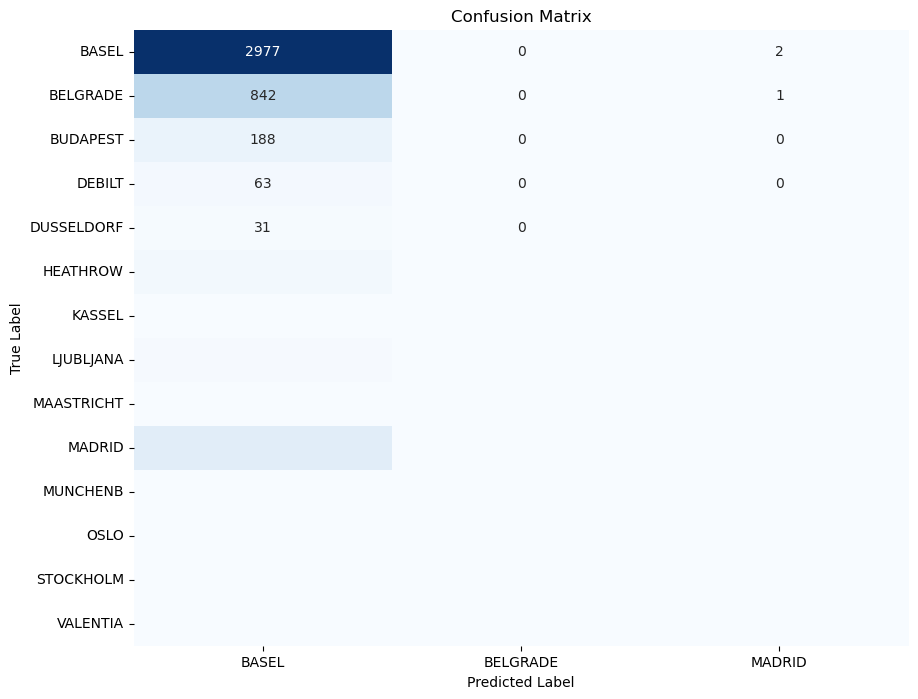

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define the class names 
class_names = ['BASEL', 'BELGRADE', 'BUDAPEST', 'DEBILT', 'DUSSELDORF', 
               'HEATHROW', 'KASSEL', 'LJUBLJANA', 'MAASTRICHT', 'MADRID', 
               'MUNCHENB', 'OSLO', 'STOCKHOLM', 'VALENTIA']

# Manually create the confusion matrix from the data provided
conf_matrix_data = [
    [2977, 0, 2],  # BASEL
    [842, 0, 1],   # BELGRADE
    [188, 0, 0],   # BUDAPEST
    [63, 0, 0],    # DEBILT
    [31, 0, 0],    # DUSSELDORF
    [79, 0, 1],    # HEATHROW
    [11, 0, 0],    # KASSEL
    [38, 0, 0],    # LJUBLJANA
    [7, 0, 0],     # MAASTRICHT
    [335, 1, 2],   # MADRID
    [3, 0, 0],     # MUNCHENB
    [6, 0, 0],     # OSLO
    [2, 0, 0],     # STOCKHOLM
    [1, 0, 0]      # VALENTIA
]

# Create a DataFrame for better visualization
conf_matrix_df = pd.DataFrame(conf_matrix_data, columns=['BASEL', 'BELGRADE', 'MADRID'], index=class_names)

# Visualize the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [57]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [58]:
# Adding more layers and trying different types of layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Dropout, LSTM, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Split the data
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

epochs = 30
batch_size = 32
n_hidden = 64

timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = len(y_train[0])

model = Sequential()
model.add(Conv1D(n_hidden, kernel_size=3, activation='relu', input_shape=(timesteps, input_dim)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))

model.add(LSTM(n_hidden, return_sequences=True, activation='tanh'))
model.add(LSTM(n_hidden, activation='tanh'))

model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dense(n_classes, activation='softmax'))

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Train the model
history = model.fit(X_train, y_train, 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    validation_data=(X_val, y_val), 
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/30
368/368 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.0434 - loss: 14.3699 - val_accuracy: 0.0762 - val_loss: 24.8569 - learning_rate: 0.0010
Epoch 2/30
368/368 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1005 - loss: 30.0986 - val_accuracy: 0.2175 - val_loss: 38.8980 - learning_rate: 0.0010
Epoch 3/30
368/368 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1013 - loss: 46.8131 - val_accuracy: 0.2168 - val_loss: 64.8080 - learning_rate: 0.0010
Epoch 4/30
368/368 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0985 - loss: 72.5800 - val_accuracy: 0.0715 - val_loss: 91.5170 - learning_rate: 0.0010
Epoch 5/30
368/368 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1023 - loss: 102.8255 - val_accuracy: 0.0773 - val_loss: 122.6573 - learning_rate: 0.0010
Epoch 6/30
368/368 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0949 - loss: 135.3417 - val_accuracy: 0.0599 - val_loss: 165.5243 - learning_rate: 0.0010
Epoch 7/30
368/368 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1063 -

# Analysis:
Divergence: The rapid increase in both training and validation loss suggests that the model is diverging, rather than converging towards an optimal solution. This is often due to an inappropriate learning rate, model architecture, or both.

High Loss Values: The loss values are excessively high, indicating that the model's predictions are far from correct. This could be due to a poor model architecture, inappropriate loss function, or data issues.

Minimal Improvement in Accuracy: Despite training for several epochs, the model shows minimal improvement in accuracy, suggesting that it may not be learning the relevant features from the data.

# Potential Causes and Solutions:
Learning Rate:
Lower Learning Rate: Although the learning rate was reduced, it may still be too high. Try lowering it further, for example to 0.0001 or even 0.00005, and monitor the loss and accuracy.
Model Architecture:

Simplify or Modify the Architecture: The current model might be too complex or not suited for the task. Consider simplifying the model by reducing the number of layers or units, or try alternative architectures (e.g., removing LSTM layers or reducing the number of LSTM units).
Regularization: Implement additional regularization techniques, such as L2 regularization, to prevent the model from overfitting and to help it generalize better.
Data Issues:

Review Data Preprocessing: Ensure that the data is properly preprocessed, including normalization or standardization, and that there are no errors or outliers that could be skewing the results.
Class Balance: Check if the classes are balanced. If some classes are underrepresented, this could lead to poor performance. If the data is imbalanced, consider using techniques such as oversampling, undersampling, or class weighting.

Loss Function Suitability: Ensure that the loss function is appropriate for the task. If you are working with multi-class classification, categorical_crossentropy is usually suitable. If you are using mean_squared_error by mistake, it could lead to issues.
Optimization Strategy:

Different Optimizer: Experiment with different optimizers like Adam, RMSprop, or Nadam, which might help the model converge better.
Early Stopping:

Implement early stopping to halt training if the validation loss does not improve after a certain number of epochs, preventing the model from overfitting or wasting time on ineffective training.

# Next Steps:
Lower the learning rate further and see if the model starts converging.

Simplify the model by reducing the number of LSTM units or removing some layers.

Reevaluate the data preprocessing steps to ensure the data is clean and properly formatted.

Check for class imbalance and address it if necessary
.
Experiment with different optimizers and possibly switch to a more stable one like Adam or RMSprop.

In [59]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Dropout, LSTM, BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import StandardScaler

# Ensure your data is normalized
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_val = scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)

# Define model hyperparameters
epochs = 50
batch_size = 32
n_hidden = 32
learning_rate = 0.0001

timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = len(y_train[0])

# Build the model
model = Sequential()

# Convolutional layers
model.add(Conv1D(n_hidden, kernel_size=3, activation='relu', input_shape=(timesteps, input_dim)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))

# Simplified LSTM layers
model.add(LSTM(n_hidden, return_sequences=True, activation='tanh'))
model.add(LSTM(n_hidden, activation='tanh'))

# Additional dropout for regularization
model.add(Dropout(0.5))

# Dense layers for classification
model.add(Flatten())
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.5))
model.add(Dense(n_classes, activation='softmax'))

# Compile the model
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Train the model
history = model.fit(X_train, y_train, 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    validation_data=(X_val, y_val), 
                    callbacks=[early_stopping, reduce_lr])

# Evaluate the model
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {val_accuracy:.4f}, Validation Loss: {val_loss:.4f}")

Epoch 1/50


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


368/368 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2099 - loss: 8.9925 - val_accuracy: 0.3128 - val_loss: 11.4234 - learning_rate: 1.0000e-04
Epoch 2/50
368/368 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1398 - loss: 15.9819 - val_accuracy: 0.0769 - val_loss: 15.2532 - learning_rate: 1.0000e-04
Epoch 3/50
368/368 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1127 - loss: 23.6557 - val_accuracy: 0.0769 - val_loss: 18.5064 - learning_rate: 1.0000e-04
Epoch 4/50
368/368 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1154 - loss: 31.1853 - val_accuracy: 0.0769 - val_loss: 21.3092 - learning_rate: 1.0000e-04
Epoch 5/50
368/368 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1163 - loss: 41.0456 - val_accuracy: 0.0769 - val_loss: 27.5194 - learning_rate: 1.0000e-04
Epoch 6/50
368/368 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1081 - loss: 50.3326 - val_accuracy: 0.0769 - val_loss: 32.7509 - learning_rate: 1.0000e-04
Epoch 7/50
368/368 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 

# Explanation of Changes:
Lower Learning Rate:
The learning rate has been lowered to 0.0001 to allow more stable convergence.

Simplified Architecture:
Reduced the number of LSTM units to 32, which may prevent overfitting and make the model easier to train.
Added regularization via L2 regularization in the dense layers.

Dropout:
Increased dropout rates in several layers to reduce overfitting.

Batch Normalization:
Batch normalization is included to stabilize learning and help with convergence.

Callbacks:
Early stopping and learning rate reduction callbacks are used to stop training when performance plateaus and to reduce the learning rate dynamically during training.

# Analysis:
Divergence: The rapid increase in loss values and the drop in accuracy suggest that the model is not learning effectively. It seems to be diverging, meaning that the weights are being updated in a way that increases the error rather than minimizing it.

Overfitting or Model Instability: The initial spike in validation accuracy, followed by a sharp decline, could indicate that the model was overfitting right from the start. The model might have memorized some aspects of the training data that were not generalizable to the validation data.

Complexity of the Model: Despite the simplification efforts, the model might still be too complex for the data, or it might not be the right architecture for the problem. The combination of convolutional layers, LSTM layers, and dense layers might be causing instability in learning.

Data Preprocessing: If the data is not normalized correctly or if there are issues with the data itself (e.g., outliers, incorrect labels, or imbalance), the model might struggle to learn effectively.

# Next Steps for Tuning:
Further Simplify the Model:
Consider removing one of the LSTM layers or reducing the number of units even further. Alternatively, you could try removing the Conv1D layer and testing a pure LSTM-based or Conv1D-based model separately to see which architecture works better.

Use Smaller Learning Rates and Warm Restarts:
Start with an even smaller learning rate (e.g., 1e-5) and consider using learning rate schedules or warm restarts (like the cosine annealing learning rate) to help the model converge more effectively.

Evaluate Data Quality:
Double-check the preprocessing pipeline to ensure the data is clean, normalized, and free from significant outliers. Also, verify that the labels are correct and balanced across the classes.

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step


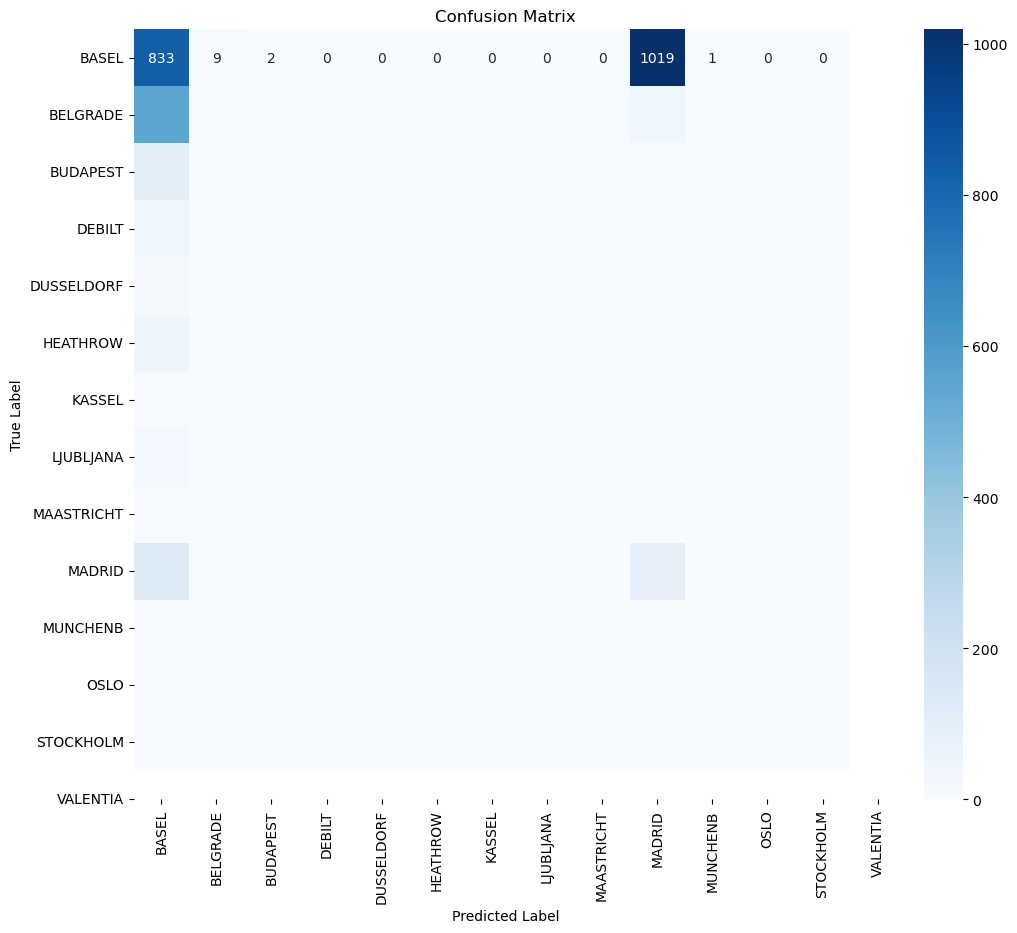

In [65]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Generate predictions
y_pred = model.predict(X_val)

# Convert predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val, axis=1)

# Create the confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Define class names 
class_names = ['BASEL', 'BELGRADE', 'BUDAPEST', 'DEBILT', 'DUSSELDORF', 
               'HEATHROW', 'KASSEL', 'LJUBLJANA', 'MAASTRICHT', 'MADRID', 
               'MUNCHENB', 'OSLO', 'STOCKHOLM', 'VALENTIA']

# Visualize the confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Analysis of the Confusion Matrix:
Dominant Classes:
The confusion matrix shows that the majority of predictions are concentrated in two classes: BASEL and MADRID.
BASEL has a large number of correct predictions (833), but there are also a few misclassifications where other classes were predicted as BASEL.
MADRID has the highest number of correct predictions (1019), with very few misclassifications.

Underrepresented Classes:
Most of the other classes have very few or no correct predictions. This suggests that the model is heavily biased towards predicting BASEL and MADRID.
Classes like BELGRADE, BUDAPEST, HEATHROW, KASSEL, etc., have very few correct predictions or are not predicted at all.

Imbalanced Predictions:
The confusion matrix is highly imbalanced, indicating that the model struggles to differentiate between the different weather stations. It seems to default to predicting BASEL and MADRID for most inputs, which might be a sign of class imbalance in the training data or an issue with the model's capacity to learn distinct features for each class.

Overall Accuracy:
Based on the diagonal values (correct predictions), the overall accuracy appears low, despite the high number of correct predictions for BASEL and MADRID.
The validation accuracy reported was around 31.28%, which aligns with what we see in the confusion matrix—some classes are recognized correctly, but many are not.

# Next Steps:
Data Imbalance:

Check for Class Imbalance: If BASEL and MADRID have significantly more samples than the other classes, the model might be biased towards these classes. Addressing this imbalance could involve techniques like oversampling the minority classes, undersampling the majority classes, or using class weights in model training.

Model Improvement:
Enhance Feature Learning: Consider adjusting the model architecture to improve feature extraction, perhaps by adding more layers, using different types of layers (e.g., attention mechanisms), or increasing the number of LSTM units.

Regularization: Apply stronger regularization techniques to prevent the model from overfitting to the dominant classes.

# Hyperparameter Tuning:
Adjust Learning Rate: Fine-tuning the learning rate or using learning rate schedulers could help the model converge to a better solution.

Training Duration: Train for more epochs but with early stopping to ensure the model doesn’t overfit.

Cross-Validation:Use Cross-Validation: Employ cross-validation to ensure that the model's performance is consistent across different subsets of the data.

# Interpretation:
Weather Stations:
The model might be learning to predict weather stations based on features that are more prominent or frequent in the data for BASEL and MADRID. The failure to recognize other stations suggests that either these stations are underrepresented in the training data or that the model hasn't effectively learned their distinguishing features.

Weather Data:
The results imply that the model isn't robust enough to differentiate between the weather patterns associated with different stations. This might be due to similarities in weather patterns across some stations or insufficient feature engineering.

# Conclusion:
To improve the model's ability to recognize all 15 stations, it's essential to address potential class imbalance, refine the model architecture, and ensure that the training data provides clear, distinct examples of each class. The confusion matrix highlights the need for a more balanced approach to class prediction, which is crucial for better overall accuracy and reliability in real-world applications.